# Decomposition of synthetic HDsEMG signals

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import os

import numpy as np
import torch

import emgkit
from load_synthetic_signal import load_synthetic_signal

logging.basicConfig(level=logging.INFO)

if torch.cuda.is_available:
    device = torch.device("cuda:0")
    logging.info("Using CUDA version")
else:
    device = torch.device("cpu")
    logging.info("Using CPU version")

SEED = 42
DATA_PATH = os.path.join("data", "synthetic_signals")
MVC = 10
SNR = 10

INFO:root:Using CUDA version


Load the HD-sEMG signal and the ground-truth spike trains.

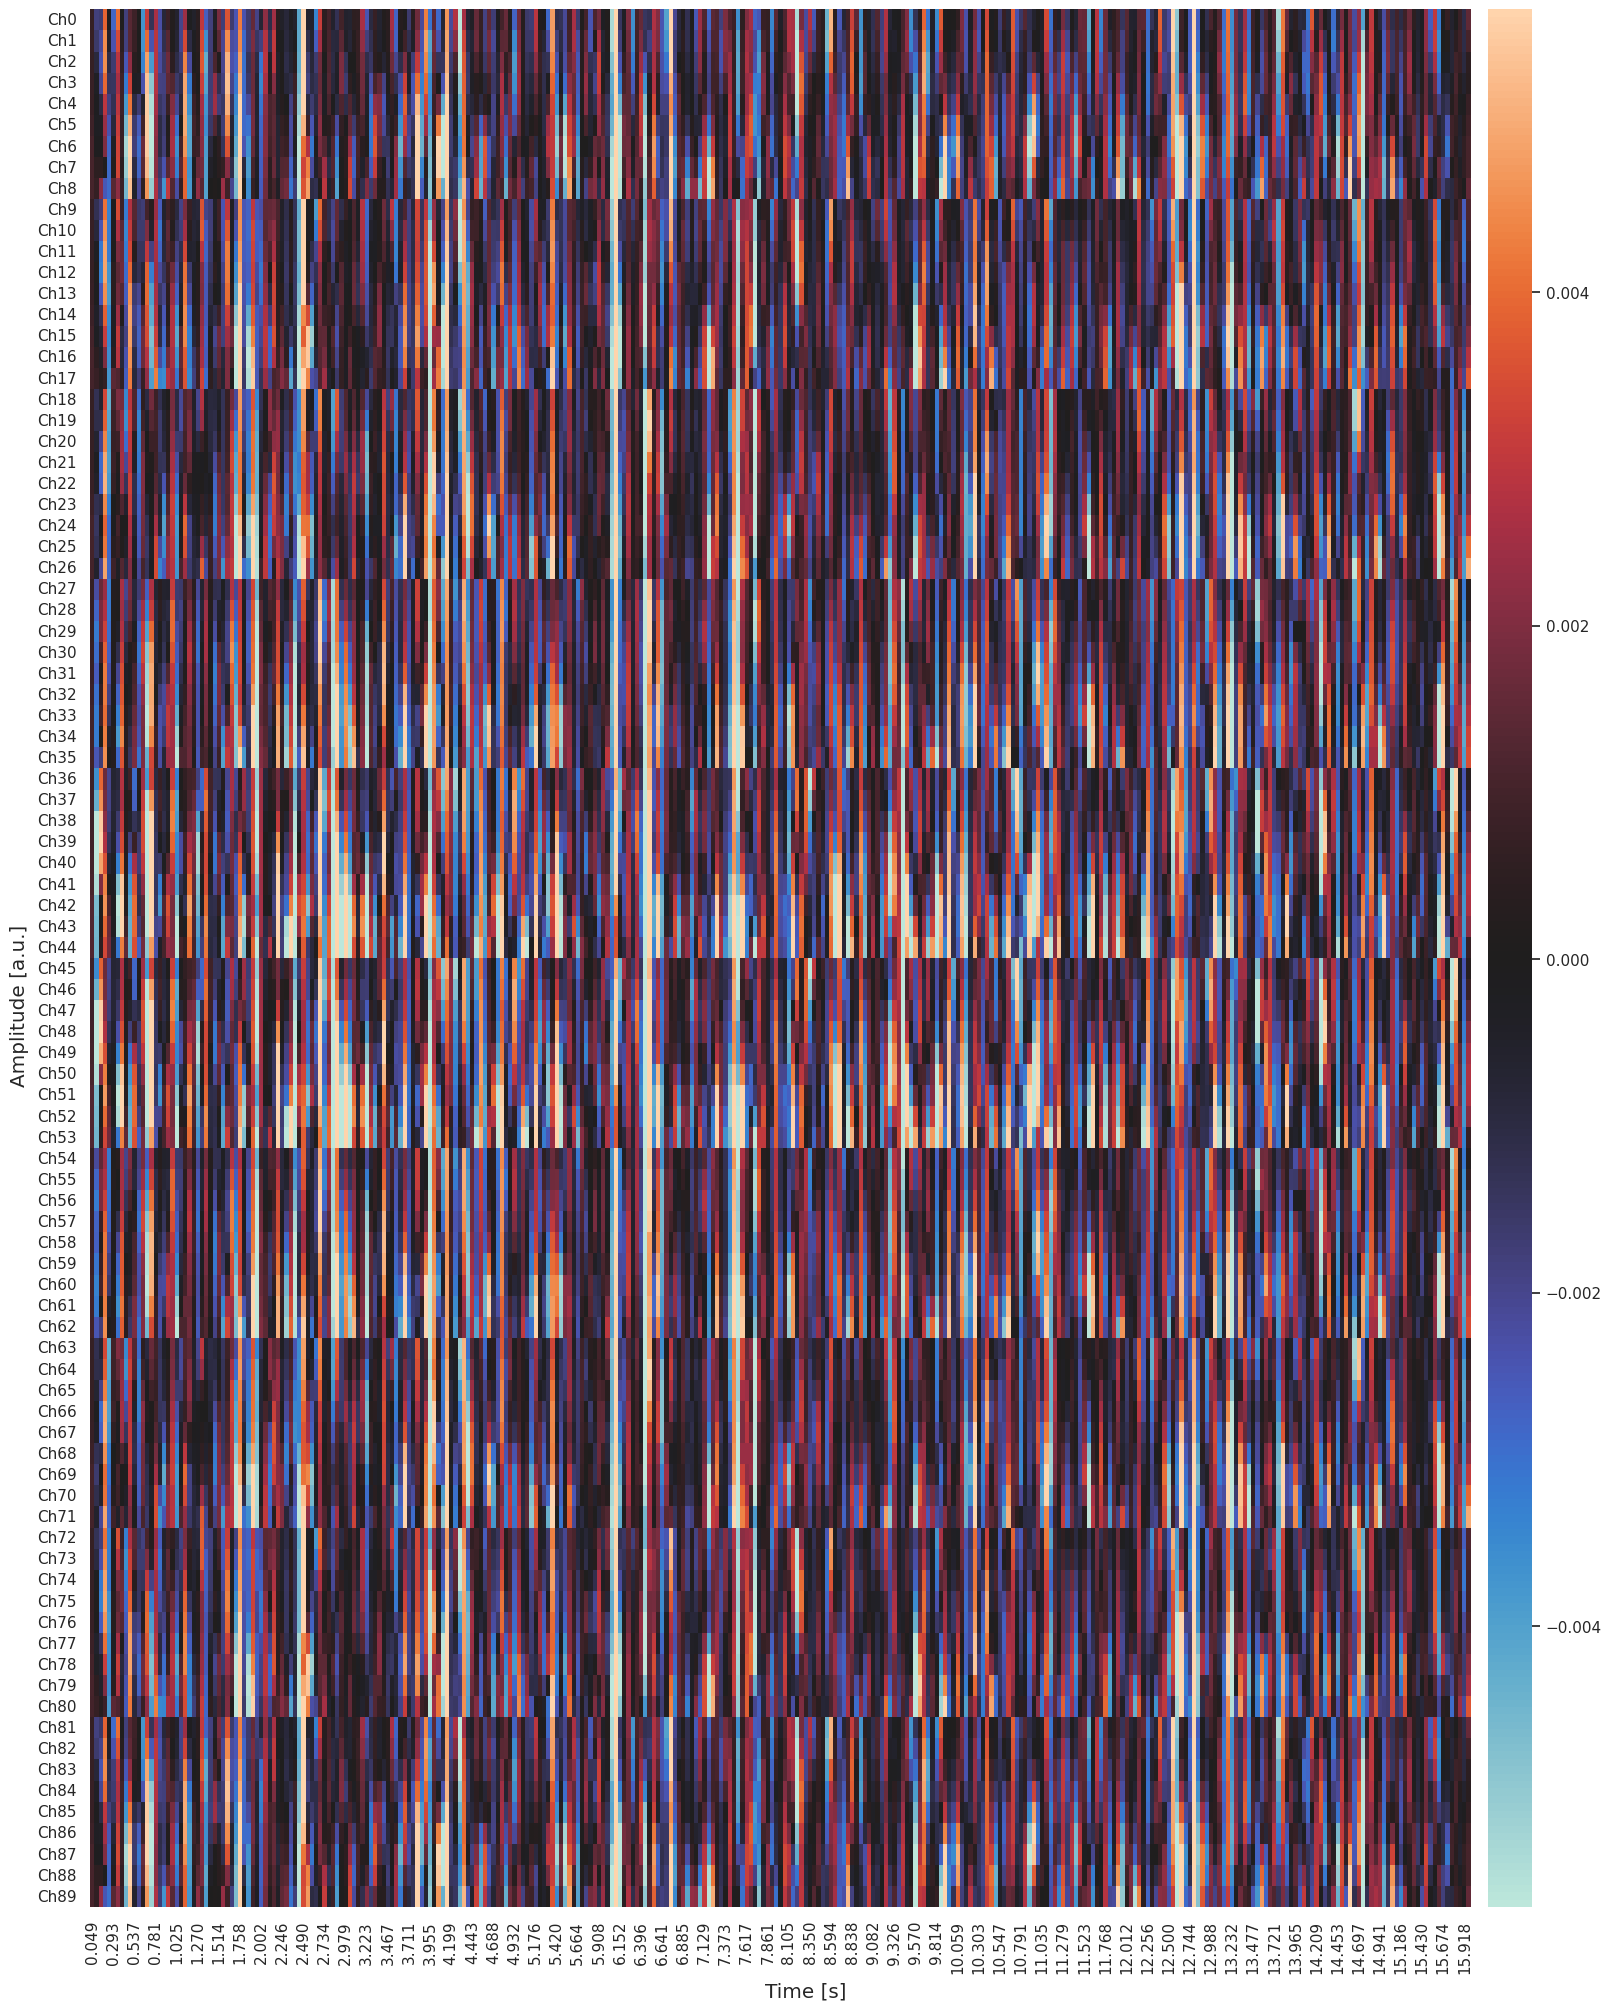

In [2]:
samples = load_synthetic_signal(DATA_PATH, mvc=MVC, snr=SNR, seed=SEED)
emg, gt_spikes_t, fs = samples[0]
sig_len_s = emg.shape[0] / fs

emgkit.plot.plot_signal(emg, fs, style="compact", fig_size=(16, 20), resolution=200)

Instantiate the decomposition model and perform the MU extraction.

In [3]:
emg_bss = emgkit.decomposition.EMGBSS(
    fs=fs,
    n_mu_target=300,
    device=device,
    seed=SEED,
    whiten_kw={
        "n_pcs": "auto",
        "keep_dim": True,
    },
)

ics, spikes_t = emg_bss.fit_transform(emg)
ext_sig_len_s = ics.shape[0] / fs

INFO:root:Number of channels before extension: 90
INFO:root:Number of channels after extension: 990
INFO:root:Instantiating PCAWhitening using "svd" solver.
INFO:root:Reducing dimension of data from 990 to 637.
INFO:root:Re-projecting dimensionality to 990.
INFO:root:----- IC 1 -----
INFO:root:FastICA converged after 11 iterations, the distance is: 8.491e-05.
INFO:root:CoV-ISI decreased from 57.53% to 17.11% after 1 steps.
INFO:root:CoV-ISI decreased from 17.11% to 13.32% after 2 steps.
INFO:root:CoV-ISI decreased from 13.32% to 13.30% after 3 steps.
INFO:root:CoV-ISI increased from 13.30% to 13.31% after 4 steps.
INFO:root:----- IC 2 -----
INFO:root:FastICA converged after 8 iterations, the distance is: 7.664e-05.
INFO:root:CoV-ISI increased from 63.97% to 68.75% after 1 steps.
INFO:root:----- IC 3 -----
INFO:root:FastICA converged after 78 iterations, the distance is: 9.404e-05.
INFO:root:CoV-ISI increased from 15.02% to 15.02% after 1 steps.
INFO:root:----- IC 4 -----
INFO:root:Fast

Plot the ICs spike trains.

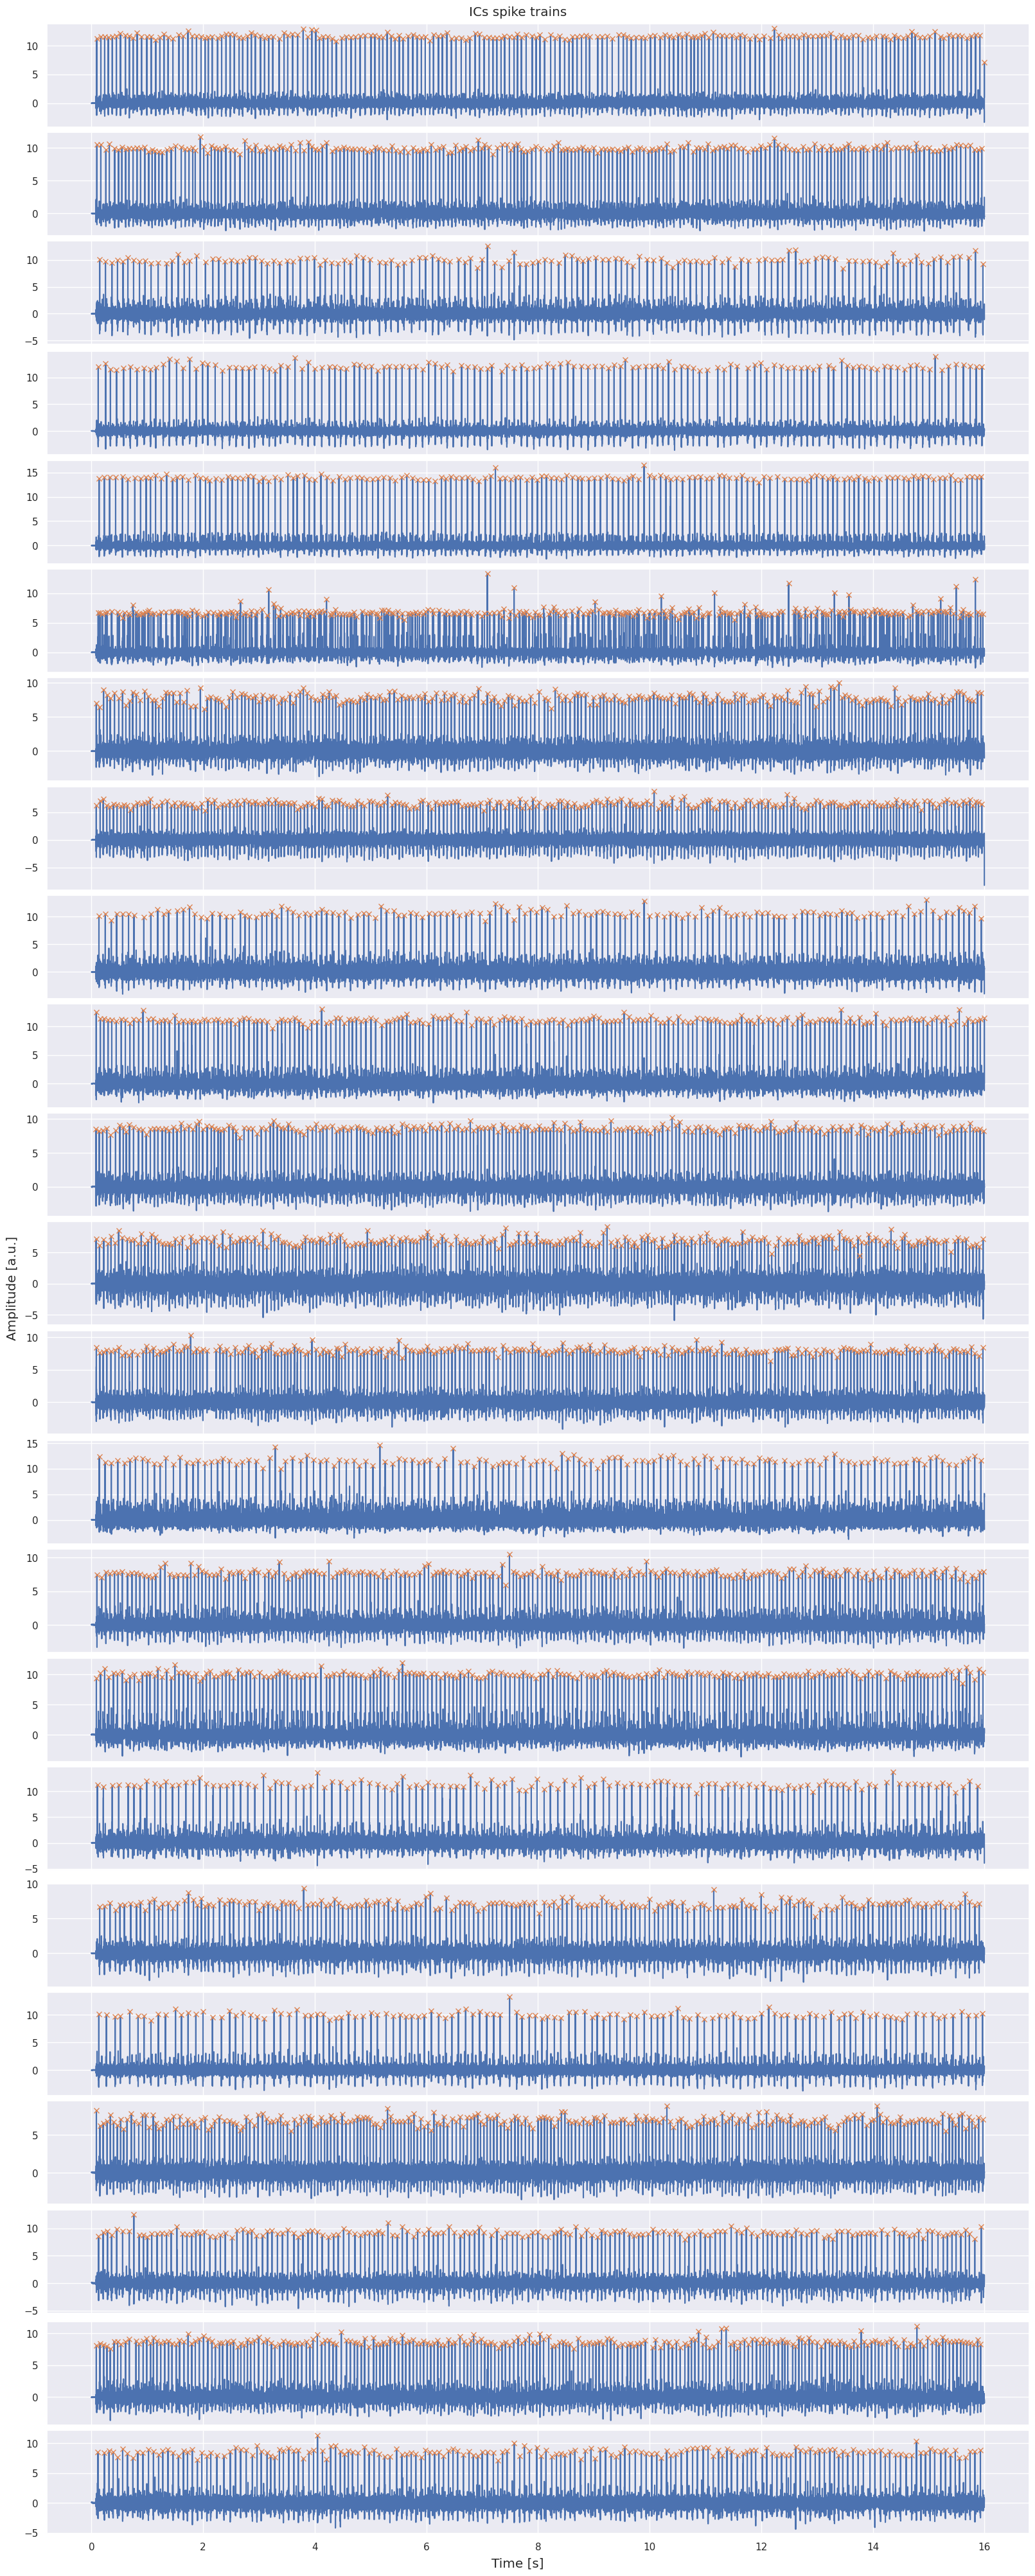

In [4]:
emgkit.plot.plot_ic_spikes(ics, spikes_t, fig_size=(16, 40))

Display the raster plot.

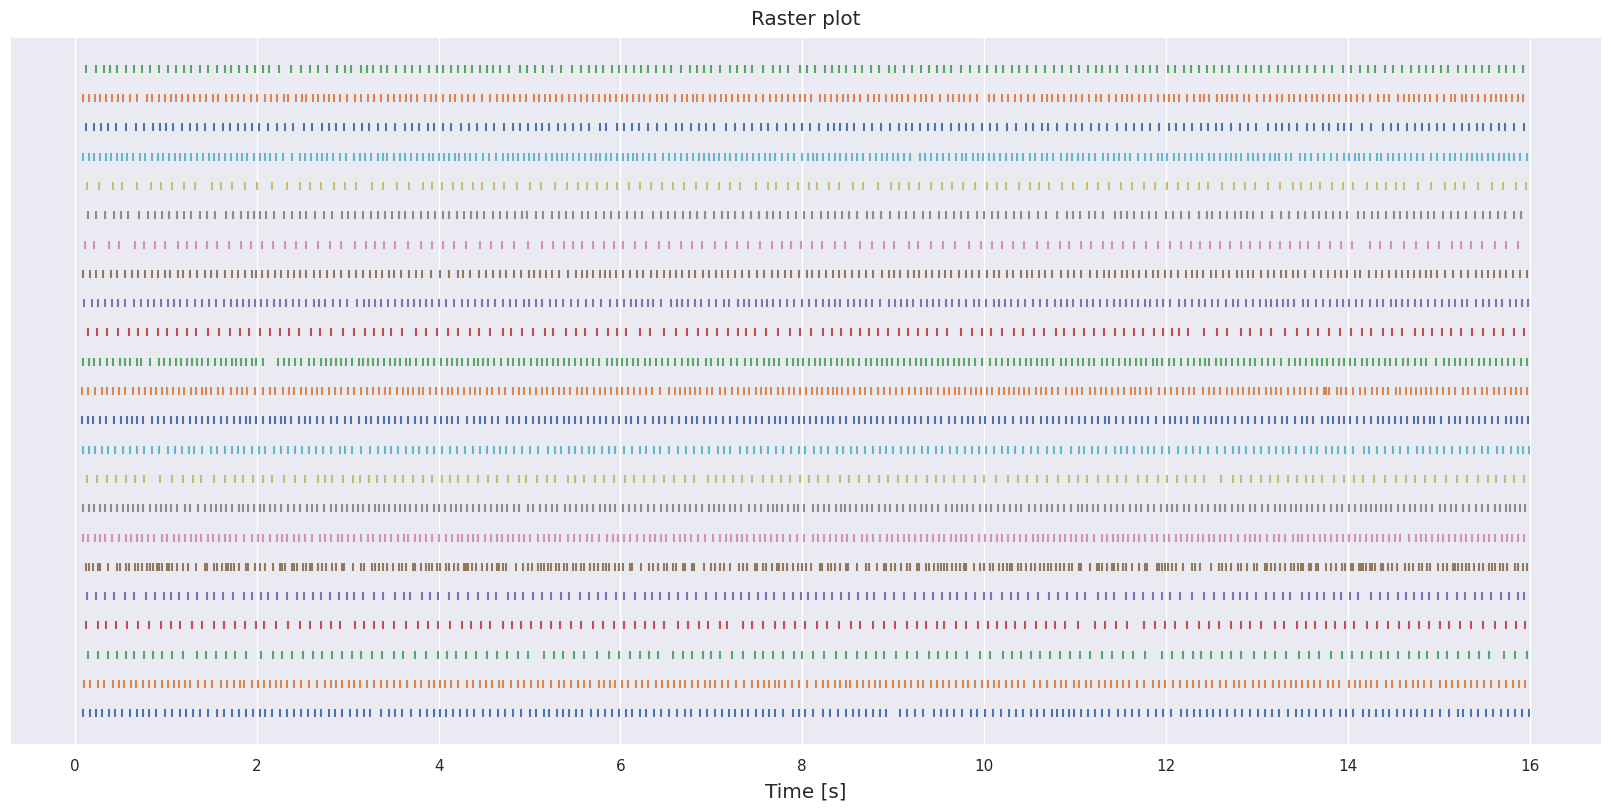

In [5]:
emgkit.plot.raster_plot(spikes_t, fig_size=(16, 8))

Display the discharge rate.

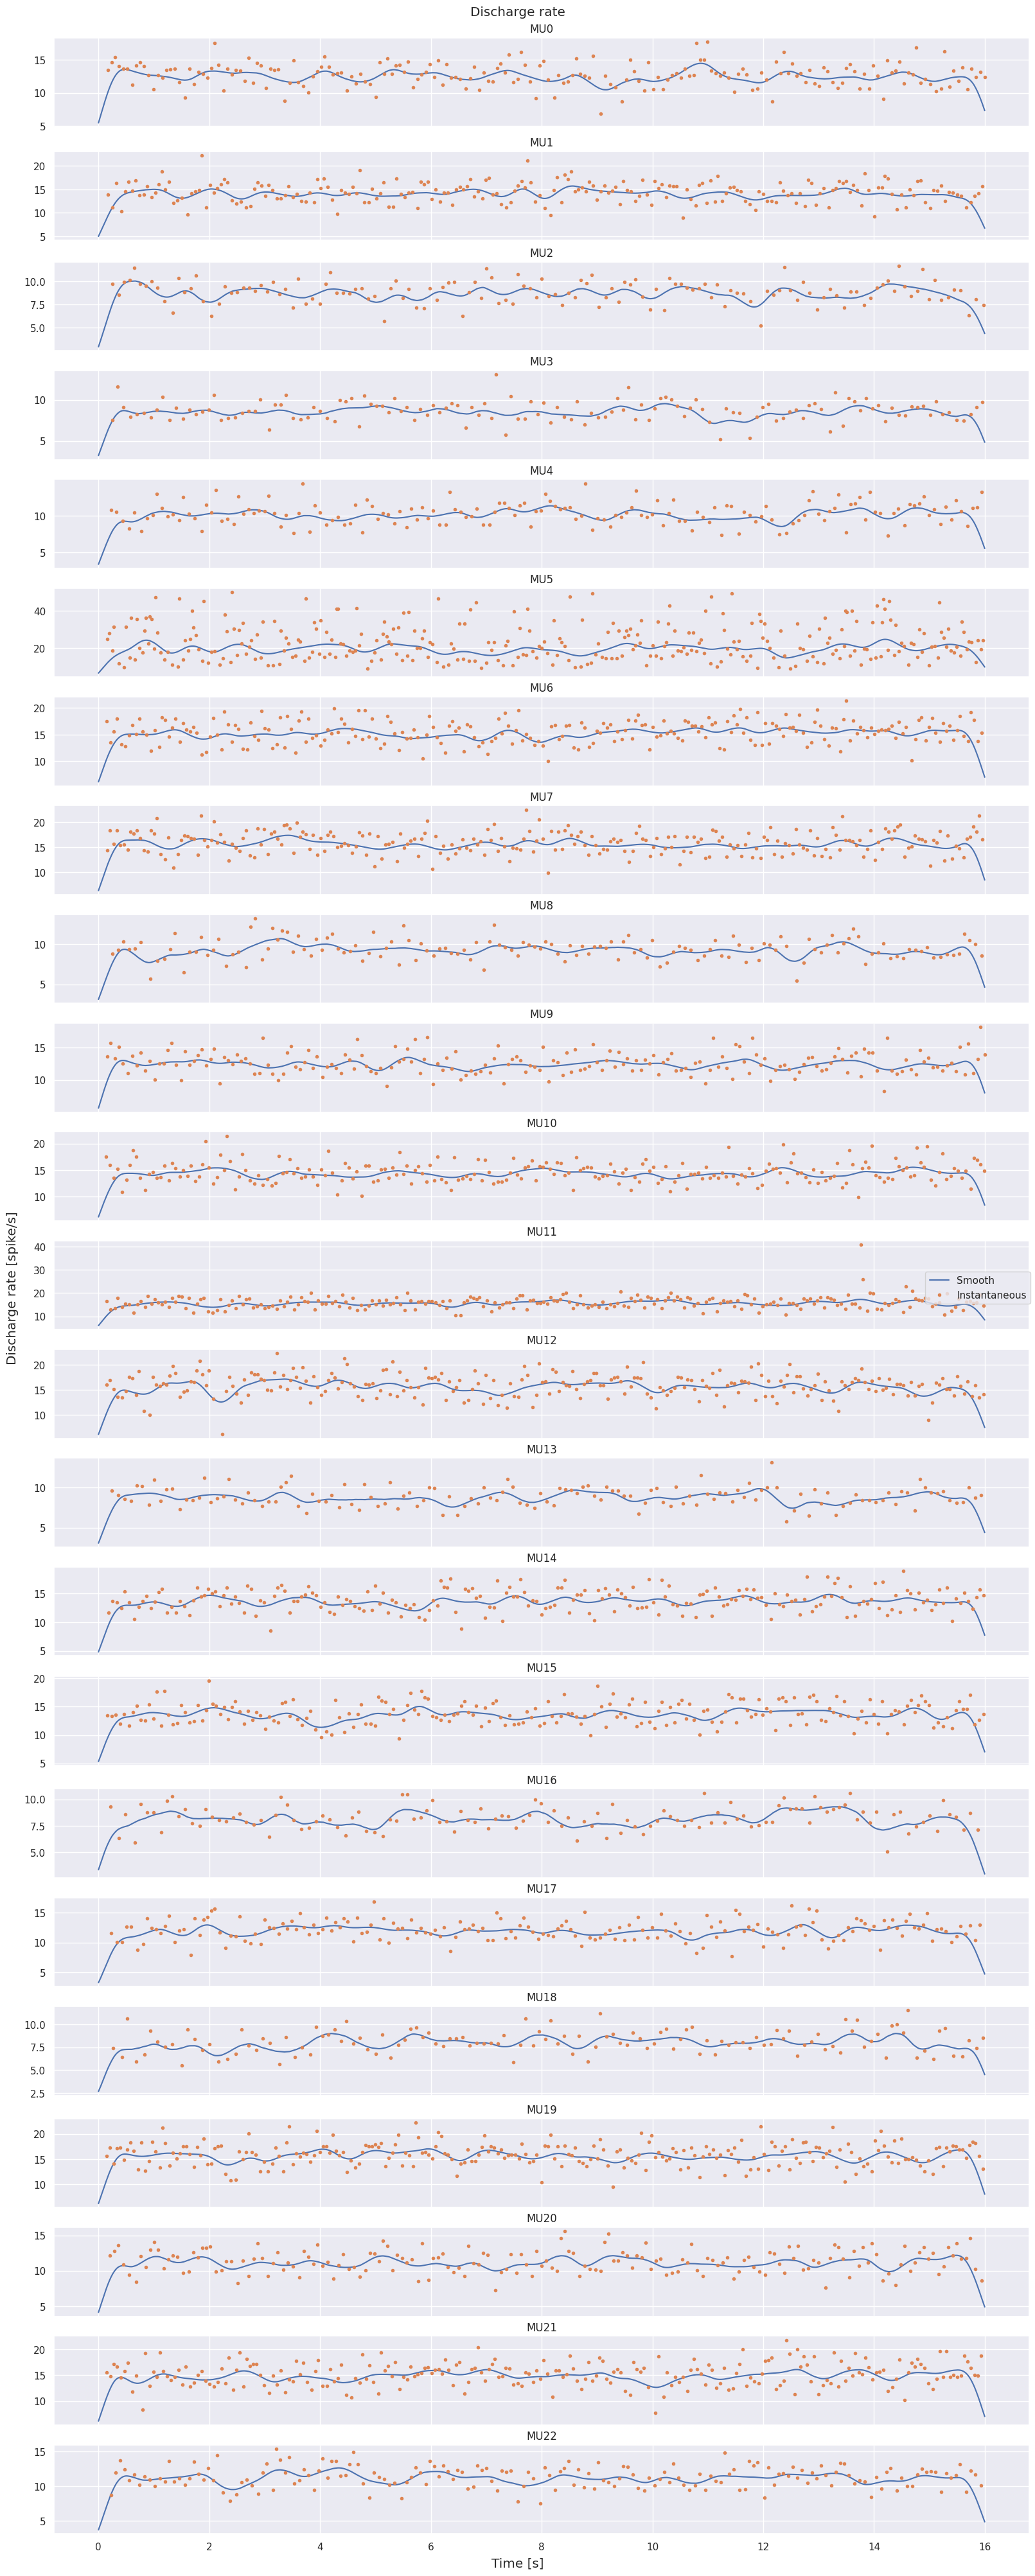

In [6]:
emgkit.plot.plot_discharges(spikes_t, ext_sig_len_s, fs, fig_size=(16, 40))

Compute the waveforms and plot them.

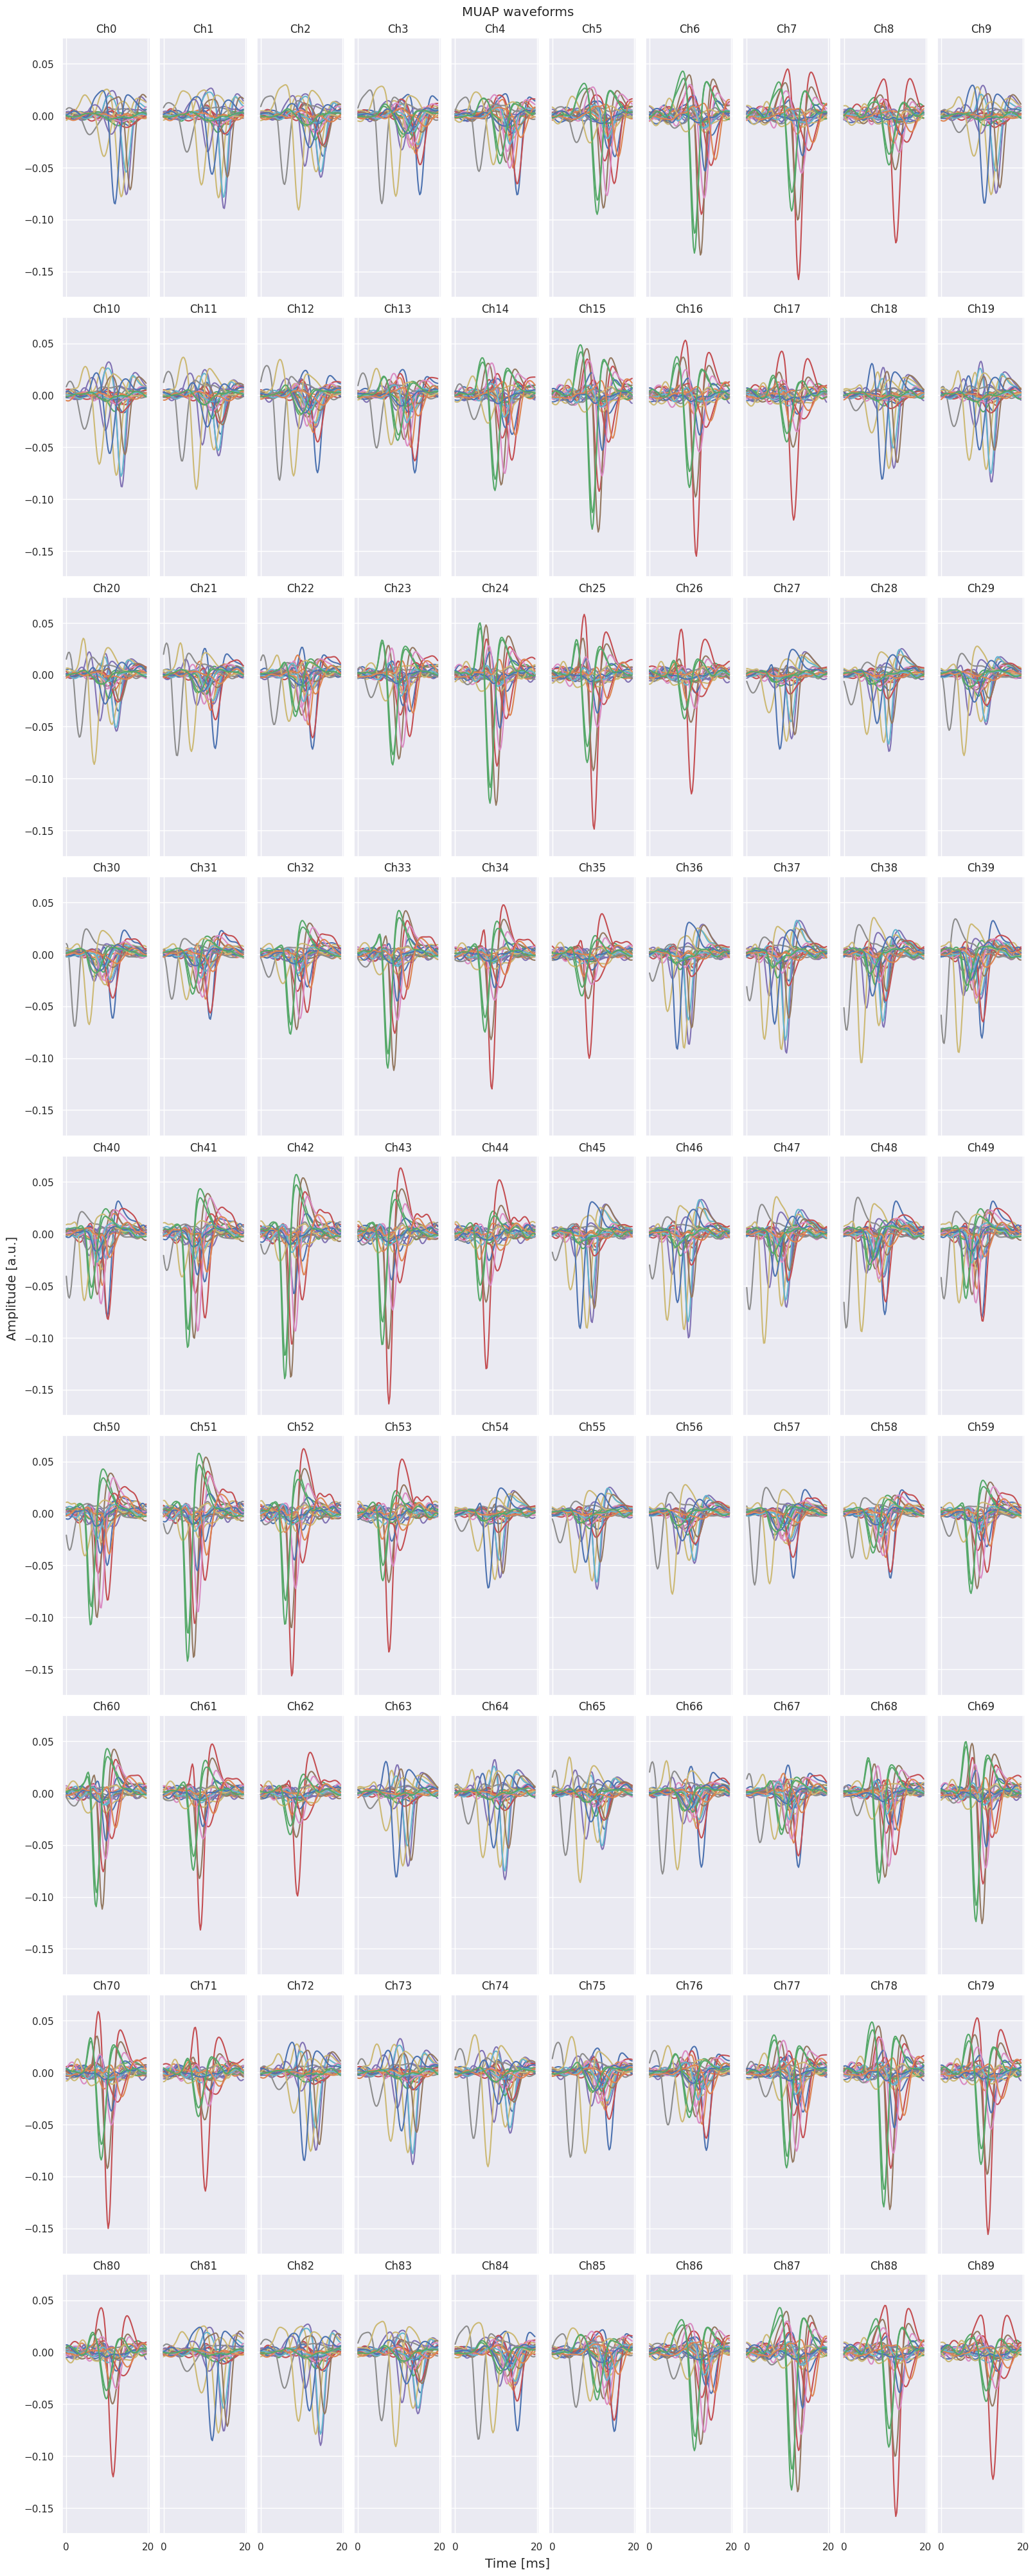

In [7]:
wfs = emgkit.utils.compute_waveforms(
    emg, spikes_t, emg_bss.f_ext, wf_radius_ms=10.0, fs=fs
)

emgkit.plot.plot_waveforms(wfs, fs=fs, fig_size=(16, 40))

Compare the extracted MUs with the ground truth.

In [8]:
# Get dense representation of spike trains
gt_spikes_bin = emgkit.utils.sparse_to_dense(gt_spikes_t, sig_len_s, fs)
spikes_bin = emgkit.utils.sparse_to_dense(spikes_t, ext_sig_len_s, fs)

# Find mappings between valid MUs and ground-truth MUs
mu_mapping = []
for i in gt_spikes_t.keys():
    for j in spikes_t.keys():
        # A spike train is valid only if it shares at least 30% of firings with ground truth
        valid, _, tp, fp, fn = emgkit.utils.check_delayed_pair(
            gt_spikes_bin[i].to_numpy(),
            np.pad(
                spikes_bin[j].to_numpy(),
                pad_width=(gt_spikes_bin.shape[0] - spikes_bin.shape[0], 0),
            ),
            fs=fs,
            tol_ms=0.5,
            min_perc=0.3,
        )
        if valid:
            # Compute metrics
            roa = tp / (tp + fn + fp)
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)

            mu_mapping.append((i, j, roa, precision, recall))
# Sort by RoA
mu_mapping = sorted(mu_mapping, key=lambda t: t[3])
# Keep unique pairs with highest RoA
valid_mus = {}
identified_mus = {}
while len(mu_mapping) != 0:
    # Pop last pair (i.e., the one with the highest RoA
    gt_mu, val_mu, roa, precision, recall = mu_mapping.pop()
    # If valid MU and ground-truth MU are not paired yet, save association
    if gt_mu not in identified_mus.keys() and val_mu not in valid_mus.keys():
        identified_mus[gt_mu] = val_mu
        valid_mus[val_mu] = (gt_mu, roa, precision, recall)

cur_valid_n_mu = len(valid_mus.keys())
cur_tot_n_mu = len(spikes_t.keys())
print(f"Extracted {cur_valid_n_mu} valid MUs out of {cur_tot_n_mu} detected.")

cur_roa_list = []
cur_precision_list = []
cur_recall_list = []
for est_mu, (gt_mu, roa, precision, recall) in valid_mus.items():
    print(f"Estimated {est_mu} <-> ground truth {gt_mu}")
    print(f"\tRoA: {roa:.2%}\tPrecision: {precision:.2%}\t Recall: {recall:.2%}")
    cur_roa_list.append(roa)
    cur_precision_list.append(precision)
    cur_recall_list.append(recall)

cur_roa_avg = np.mean(cur_roa_list)
cur_roa_std = np.std(cur_roa_list)
cur_precision_avg = np.mean(cur_precision_list)
cur_precision_std = np.std(cur_precision_list)
cur_recall_avg = np.mean(cur_recall_list)
cur_recall_std = np.std(cur_recall_list)
print(f"Average RoA: {cur_roa_avg:.2f} ± {cur_roa_std:.2f}")
print(f"Average precision: {cur_precision_avg:.2f} ± {cur_precision_std:.2f}")
print(f"Average recall: {cur_recall_avg:.2f} ± {cur_recall_std:.2f}")

Extracted 23 valid MUs out of 23 detected.
Estimated MU18 <-> ground truth MU259
	RoA: 100.00%	Precision: 100.00%	 Recall: 100.00%
Estimated MU16 <-> ground truth MU257
	RoA: 99.23%	Precision: 100.00%	 Recall: 99.23%
Estimated MU2 <-> ground truth MU251
	RoA: 100.00%	Precision: 100.00%	 Recall: 100.00%
Estimated MU3 <-> ground truth MU250
	RoA: 100.00%	Precision: 100.00%	 Recall: 100.00%
Estimated MU13 <-> ground truth MU249
	RoA: 100.00%	Precision: 100.00%	 Recall: 100.00%
Estimated MU8 <-> ground truth MU243
	RoA: 100.00%	Precision: 100.00%	 Recall: 100.00%
Estimated MU4 <-> ground truth MU227
	RoA: 100.00%	Precision: 100.00%	 Recall: 100.00%
Estimated MU22 <-> ground truth MU210
	RoA: 100.00%	Precision: 100.00%	 Recall: 100.00%
Estimated MU20 <-> ground truth MU205
	RoA: 100.00%	Precision: 100.00%	 Recall: 100.00%
Estimated MU17 <-> ground truth MU200
	RoA: 99.47%	Precision: 100.00%	 Recall: 99.47%
Estimated MU9 <-> ground truth MU180
	RoA: 100.00%	Precision: 100.00%	 Recall: 100.00